# Kaggle Review

Despite the context of this project not being focused on strong results, the horrendous MSE and R^2 values I ended with are incredibly bothersome to me. I'm currently under the assumption that the data has an extreme price difference between the luxury and more affordable vehicles. Whether this is something that could be addressed through some sort of classification is currently beyond me. Moreover, I need to work on more ways to interpret and graph the data.

That being said, I think this is a perfect opportunity to compare the top submissions for this data and expand my ML toolkit. They seem to expand upon the data a bit, so my takeaways will be largely conceptual. Let's see if I can translate some of these submissions to my own use case.

# First Example

The first comparison example can be found [here](https://www.kaggle.com/code/satyaprakashshukl/used-car-price-prediction). Let's take a look at what they did.

Interestingly, they have `lightgbm` in their imports. While I attempted to use this library for missing value imputation, I also considered learning how to use it for the price predictions as well. Given that it was an entire learning rabbit hole to go down, I decided to abandon it. Nice to see I had the right idea though.

Here's all the imports this guy used:

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from dython.nominal import associations
import category_encoders as ce

Moreover, while I was using MSE for simplicity (and just to get things done), this gentleman uses **Root Mean Squared Error (RMSE)**.

According to [Reddit](https://www.reddit.com/r/learnmachinelearning/comments/s98fsr/whats_the_difference_between_mse_and_rmse_and_why/) (I'll use better resources when I actually apply this metric to my own use cases), "the MSE gives us the average squared error, but it's not in the same units as the value we are trying to predict. The RMSE is the square root of the MSE, so now we have the prediction error in the same units of the predicted value."

"In short, RMSE is more intuitive to 'see' whereas MSE is more useful mathematically. Same for variance vs. STD."

Let's get the data ready to loosely follow along.

In [250]:
df = pd.read_csv("data/used_cars.csv")
df.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
5,Acura,ILX 2.4L,2016,"136,397 mi.",Gasoline,2.4 Liter,F,Silver,Ebony.,None reported,NaN,"$14,798"
6,Audi,S3 2.0T Premium Plus,2017,"84,000 mi.",Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,"$31,000"
7,BMW,740 iL,2001,"242,000 mi.",Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,"$7,300"
8,Lexus,RC 350 F Sport,2021,"23,436 mi.",Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,"$41,927"
9,Tesla,Model X Long Range Plus,2020,"34,000 mi.",NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,"$69,950"


I'm also noticing that he split the data before doing anything else, while I split the data pretty late into my code. I have a feeling it's best practice to split the data right off the bat.

They also split the data into `df_train` and `df_test` before splitting into the feature and target variables. Likely for the purpose of inspecting the data before doing the actual split.

In [251]:
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42)

In [252]:
df_train.shape, df_test.shape

((3207, 12), (802, 12))

In [253]:
df_train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [254]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3207 entries, 2473 to 3174
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         3207 non-null   object
 1   model         3207 non-null   object
 2   model_year    3207 non-null   int64 
 3   milage        3207 non-null   object
 4   fuel_type     3080 non-null   object
 5   engine        3207 non-null   object
 6   transmission  3207 non-null   object
 7   ext_col       3207 non-null   object
 8   int_col       3207 non-null   object
 9   accident      3116 non-null   object
 10  clean_title   2737 non-null   object
 11  price         3207 non-null   object
dtypes: int64(1), object(11)
memory usage: 325.7+ KB


In [255]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 802 entries, 2580 to 621
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         802 non-null    object
 1   model         802 non-null    object
 2   model_year    802 non-null    int64 
 3   milage        802 non-null    object
 4   fuel_type     759 non-null    object
 5   engine        802 non-null    object
 6   transmission  802 non-null    object
 7   ext_col       802 non-null    object
 8   int_col       802 non-null    object
 9   accident      780 non-null    object
 10  clean_title   676 non-null    object
 11  price         802 non-null    object
dtypes: int64(1), object(11)
memory usage: 81.5+ KB


In [256]:
df_train.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       127
engine            0
transmission      0
ext_col           0
int_col           0
accident         91
clean_title     470
price             0
dtype: int64

In [257]:
df_test.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type        43
engine            0
transmission      0
ext_col           0
int_col           0
accident         22
clean_title     126
price             0
dtype: int64

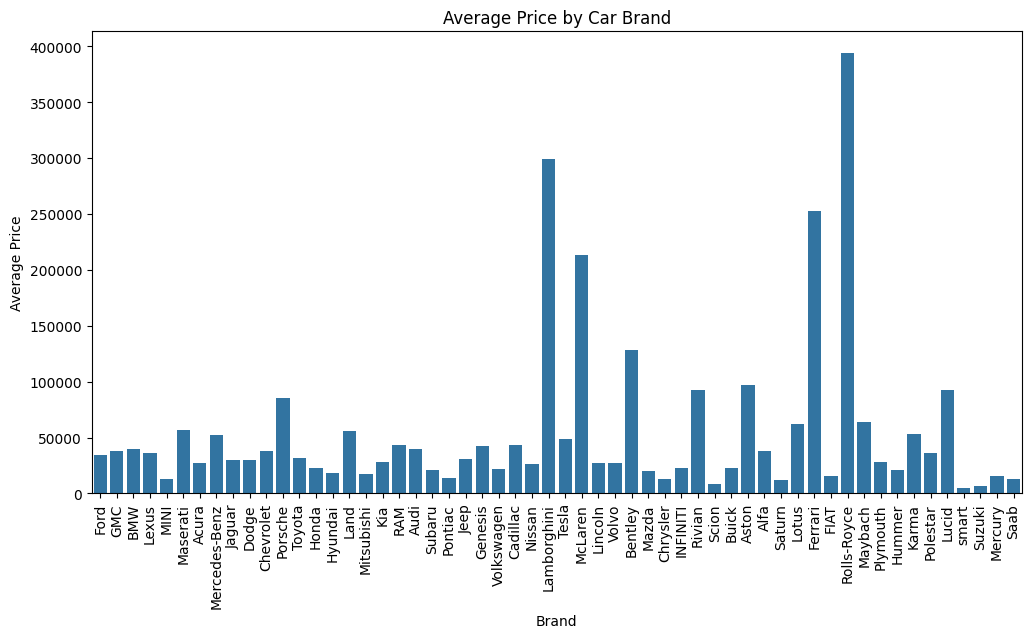

In [258]:
df_train['price'] = df_train['price'].str.replace('$', '').str.replace(',', '').astype(float)
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='price', data=df_train, errorbar=None)
plt.title("Average Price by Car Brand")
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.xticks(rotation=90)
plt.show()

Well... it's clear that this is a major step I missed in the data inspection, regardless of my intention to learn graphing at a later time. This was an easy graph to obtain.

Now here's a more nuanced boxplot he included as well:

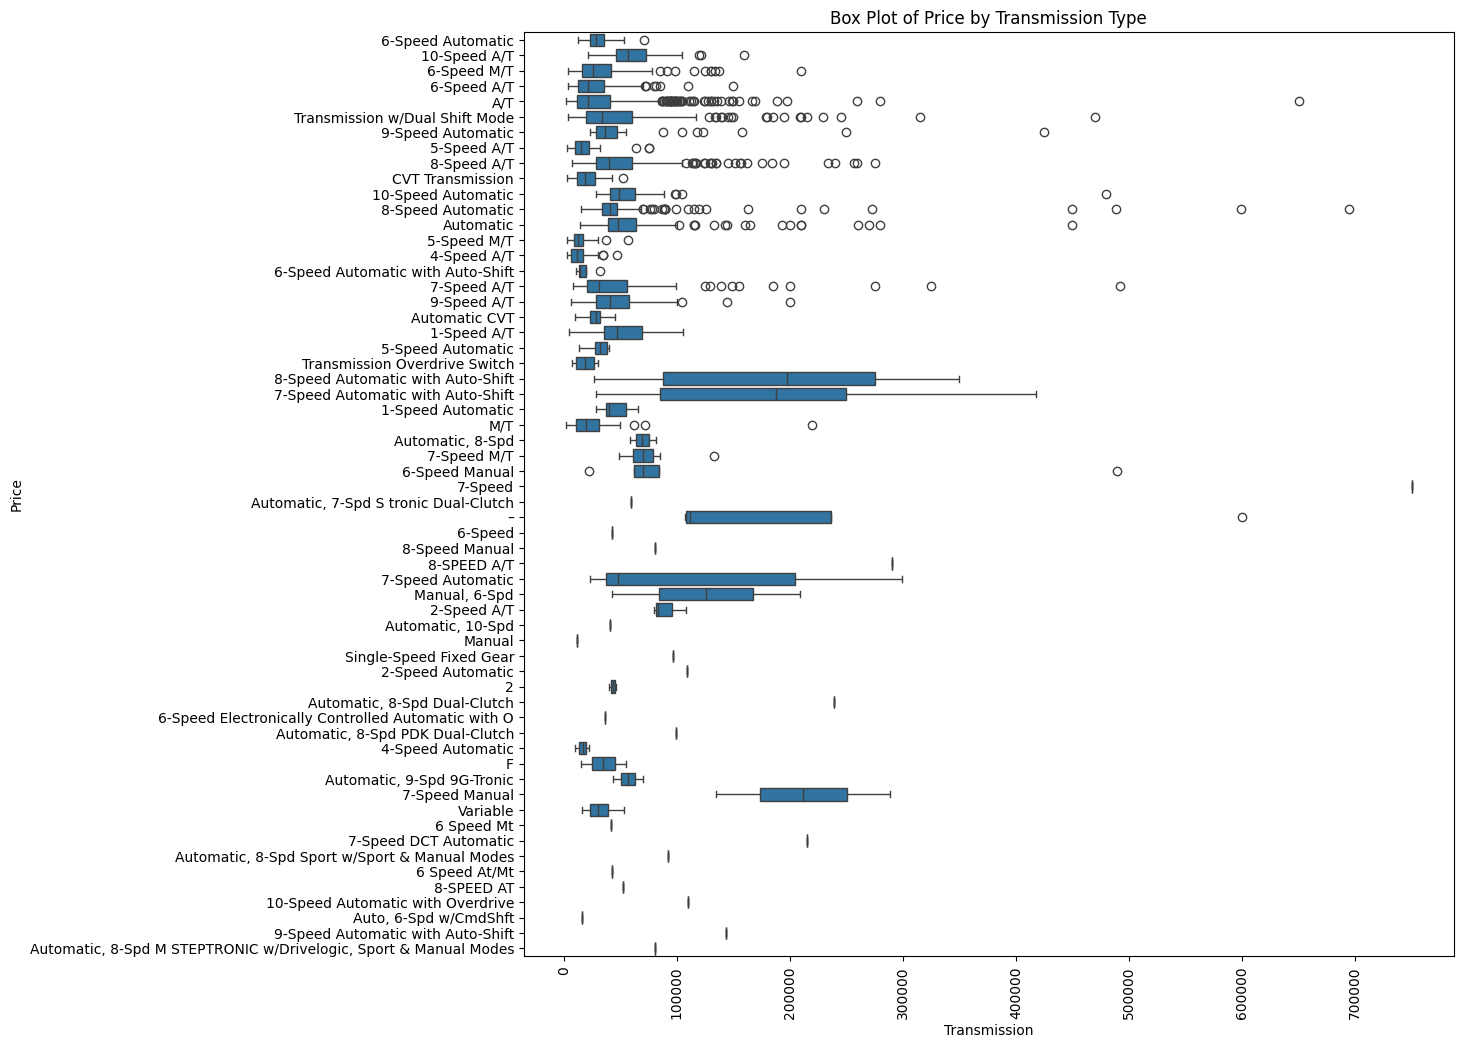

In [259]:
plt.figure(figsize=(12, 12))
sns.boxplot(x="price", y="transmission", data=df_train, orient='h')
plt.title("Box Plot of Price by Transmission Type")
plt.xlabel("Transmission")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.show()

Another value piece of data inspection knowledge. I haven't looked into it yet, but he doesn't have any type conversions in his code. Likely getting the data in a more "official" way than my method of just downloading a csv. 

As a quick side note, I'm going to start using single instead of double quotes.

Here's another plot for average price by accident history:

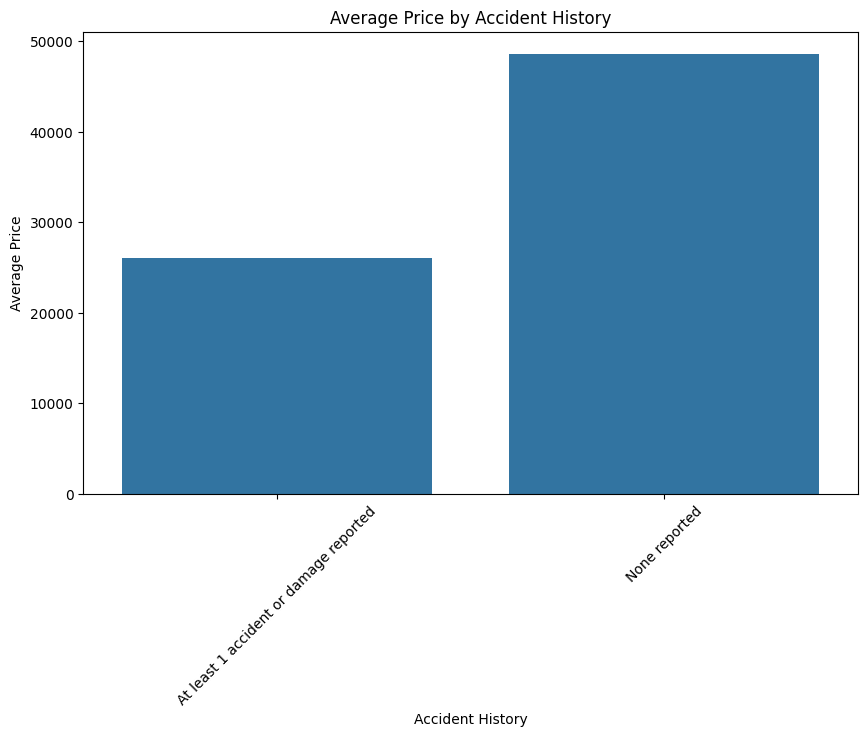

In [260]:
plt.figure(figsize=(10, 6))
sns.barplot(x='accident', y='price', data=df_train, errorbar=None)
plt.title('Average Price by Accident History')
plt.xlabel('Accident History')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

Now he shows the count of df_train by fuel type.

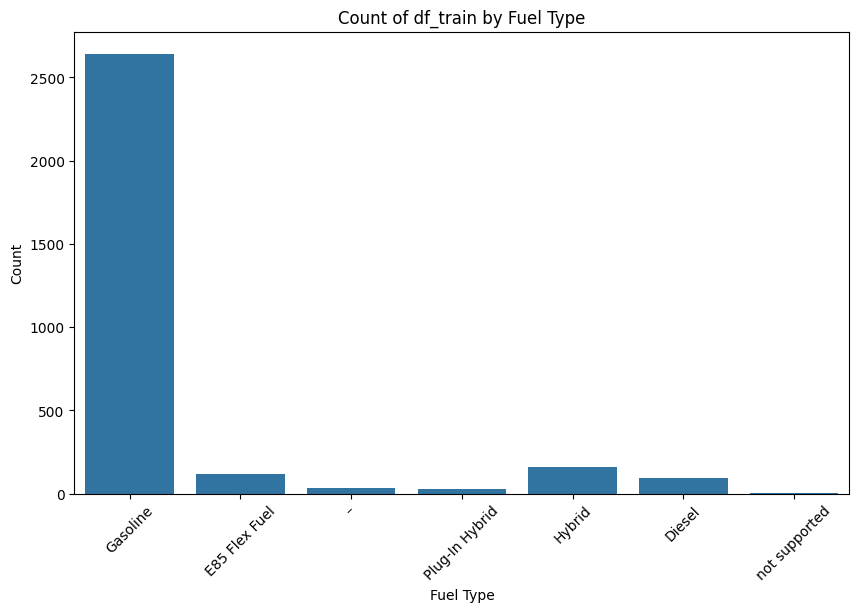

In [261]:
plt.figure(figsize=(10, 6))
sns.countplot(x='fuel_type', data=df_train)
plt.title('Count of df_train by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Count of df_train by transmission type:

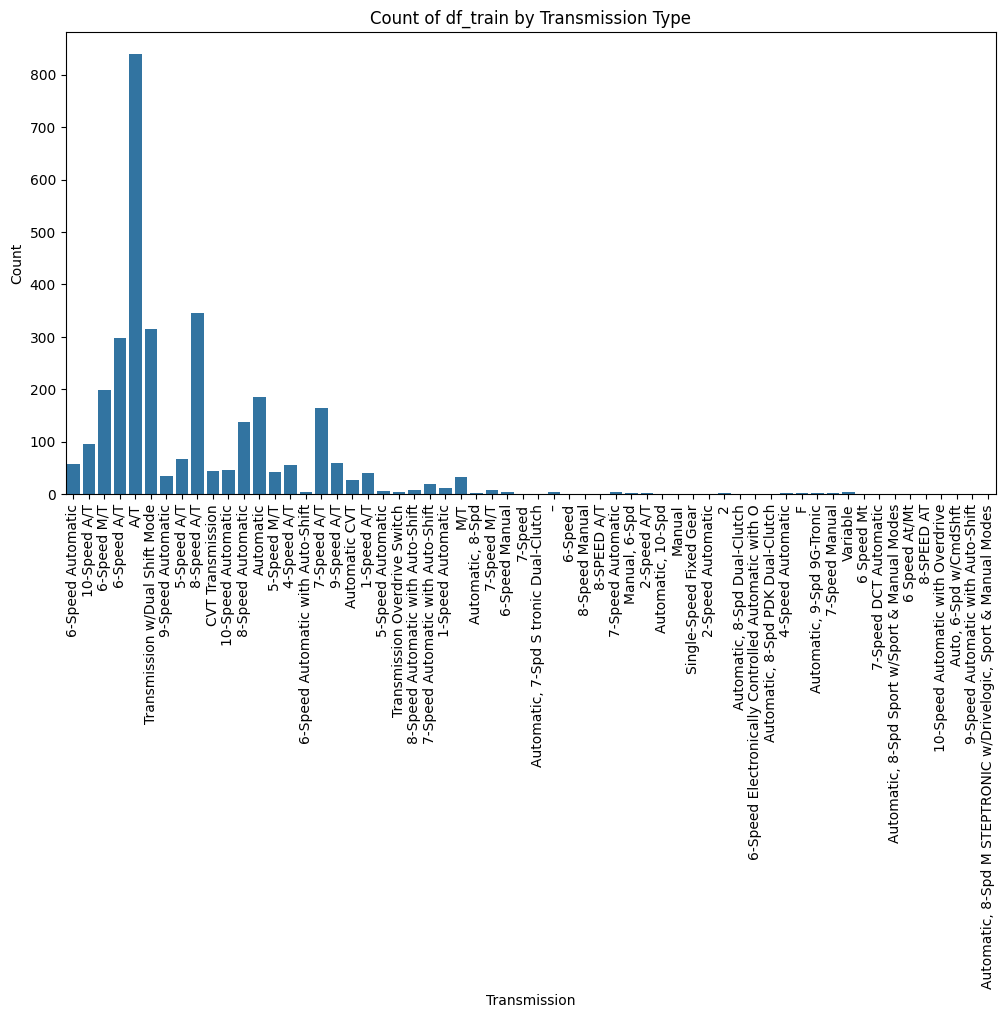

In [262]:
plt.figure(figsize=(12, 6))
sns.countplot(x='transmission', data=df_train)
plt.title('Count of df_train by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Gonna have to do some heavy handed categorical column assigning here just to keep things consistent with the example code and maintain simplicity.

In [263]:
categorical_columns = df_train[['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']]
unique_values = {col: df_test[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")
gc.collect()

brand: 49 unique values
model: 631 unique values
fuel_type: 6 unique values
engine: 493 unique values
transmission: 34 unique values
ext_col: 104 unique values
int_col: 55 unique values
accident: 2 unique values
clean_title: 1 unique values


82026

I'm very interested in his use of `gc` as well. Sounds like something I'll need for memory management when I start dealing with more complex code.

## Exploratory Data Analysis

This is certainly a part of my attempt (like many others) that was *seriously* lacking. Again... I was just trying to get an end result and practice organizing the data and running regressions on it. However, I feel I may have been too focused on the end result. Thankfully I'm doing this review now.

In [264]:
missing_train = df_train.isna().mean() * 100
missing_test = df_test.isna().mean() * 100

print("Columns in df_train with more than 10% missing values:")
print(missing_train[missing_train > 0])

print("\nColumns in df_test with more than 10% missing values:")
print(missing_test[missing_test > 0])

Columns in df_train with more than 10% missing values:
fuel_type       3.960087
accident        2.837543
clean_title    14.655441
dtype: float64

Columns in df_test with more than 10% missing values:
fuel_type       5.361596
accident        2.743142
clean_title    15.710723
dtype: float64


It seems like their print statement is misaligned with their code logic. No matter. Looks like they're just checking if the given column has more than 0 missing values. Let's just keep going and not worry about it.

/var/folders/m_/f7m4q3pj7j3f6tby_sb7n5280000gn/T/ipykernel_1087/3862841601.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')


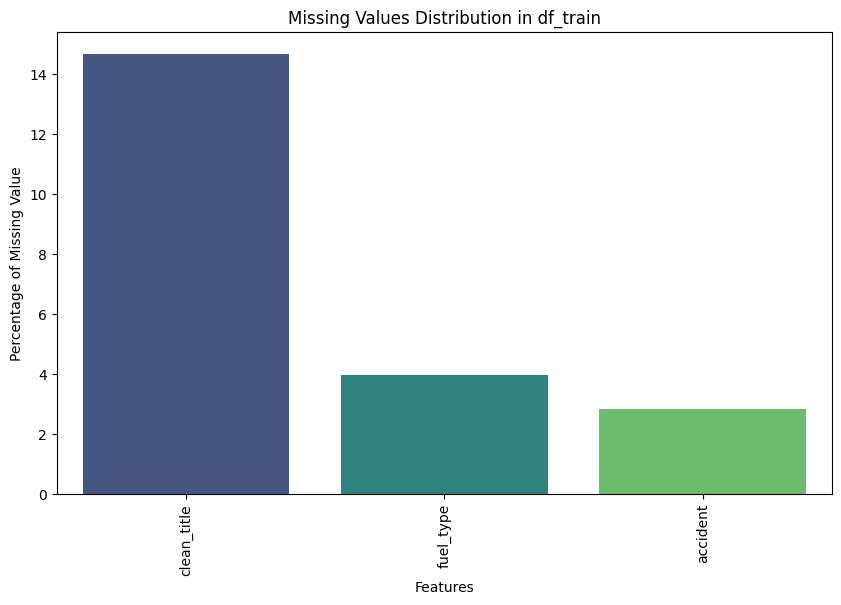

In [265]:
missing_values = df_train.isnull().mean() * 100
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Value')
plt.title('Missing Values Distribution in df_train')
plt.show()

He then lists `!pip install dython` after this code. What the heck is this? Well let's find out.

Dython is a set of data analysis tools for python that can "let you get mor insights about your data". Probably the most noteworthy thing about this library is that "production-grade performance" was not considered.

Their documentation has some unusual markdown errors on their welcome page... which isn't exactly reassuring for the quality of the library. Oh well... let's see where this takes us anyway.

His usage of the library `category_encoders` is also a bit strange as well. Why use this in addition to the `sklearn` options? Again... let's just find out... the emojis and colors of his notebook are also driving me a bit nuts.

Something that does give me some comfort is that we're about to make a heatmap, which I originally intended to do, but didn't feel it was necessary for my requirement of "just getting it done". Also, wouldn't it make more sense to create a heatmap much earlier?

I'm gonna have to double check the data types before creating the heatmap. I'll borrow some of my own code to speed up the conversions as well.

In [266]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3207 entries, 2473 to 3174
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         3207 non-null   object 
 1   model         3207 non-null   object 
 2   model_year    3207 non-null   int64  
 3   milage        3207 non-null   object 
 4   fuel_type     3080 non-null   object 
 5   engine        3207 non-null   object 
 6   transmission  3207 non-null   object 
 7   ext_col       3207 non-null   object 
 8   int_col       3207 non-null   object 
 9   accident      3116 non-null   object 
 10  clean_title   2737 non-null   object 
 11  price         3207 non-null   float64
dtypes: float64(1), int64(1), object(10)
memory usage: 325.7+ KB


In [267]:
df_train[["milage", "price"]] = df_train[["milage", "price"]].replace(r'[^\d.]', '', regex=True).astype("float64")  
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3207 entries, 2473 to 3174
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         3207 non-null   object 
 1   model         3207 non-null   object 
 2   model_year    3207 non-null   int64  
 3   milage        3207 non-null   float64
 4   fuel_type     3080 non-null   object 
 5   engine        3207 non-null   object 
 6   transmission  3207 non-null   object 
 7   ext_col       3207 non-null   object 
 8   int_col       3207 non-null   object 
 9   accident      3116 non-null   object 
 10  clean_title   2737 non-null   object 
 11  price         3207 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 325.7+ KB


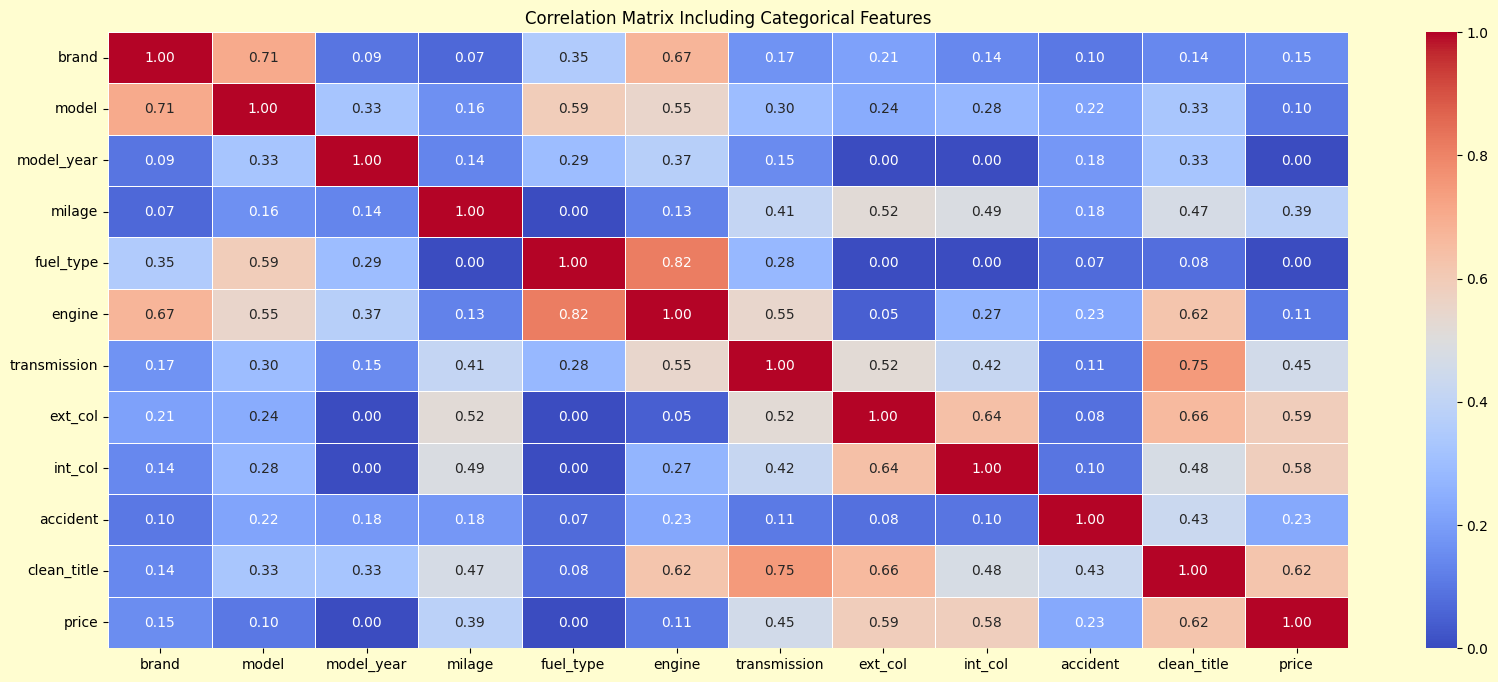

In [268]:
associations_df = associations(df_train, nominal_columns="all", plot=False) # Can't we just use numpy for this?
corr_matrix = associations_df["corr"]
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0')
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Including Categorical Features')
plt.show()

Yea I really don't understand why he's using `dython` here. Can't you just make a correlation matrix with `numpy` or `pandas`? Let's see if my method yields the same results.

Update: it seems like `dython` might automatically handle string values to simplify the correlation matrix creation. This is not fully confirmed, but highly likely.

Now let's summarize the data quality issues he identified (without emojis).

**Missing Values:** fuel_type: 2.69% missing (4,040 entries missing) accident: 1.28% missing (1,923 entries missing) clean_title: 11.32% missing (16,981 entries missing)

**Modification Required:** Impute missing values using mode or a constant placeholder such as 'Unknown' for categorical columns.

**High Cardinality:** Columns like brand, transmission, ext_col, and int_col have many unique values (rare categories). **This is something I didn't think to consider during my attempt**.

**Modification Required:** Consider grouping rare categories into a single "Other" category to reduce cardinality. For ext_col and int_col, which have high cardinality, consider using hash encoding or text embedding techniques.

**Mixed Data Types:** fuel_type and accident columns have mixed data types (e.g., objects and floats). Suggestions: Convert these columns to a single consistent data type (e.g., string) before encoding.

**Low Information Column:** clean_title: Identified as a possible low-information column with high missingness (11.32%).

**Modification Required:** Better dropping these column before modeling since it provides little to no additional information.

**Possible Date-Time Column:** model_year is recognized as a potential date-time column, which could represent the age of the vehicle. Suggestions: Transform model_year into a feature representing the vehicle's age by calculating the difference from the current year.

Well... it's pretty clear he used AI for this summary. Two noteworthy points here I forgot to consider during my first rushed attempt: high cardinality and converting to date time (I considered this, but simply forgot to do it).

# Some Thoughts

* Hey would you look at that, he's about to impute the missing values with `KNNImputer` like I did. I noticed that this had the highest R^2 other than the complete removal of missing values that I did as well.
* I'm also worried that this guy might've been heavily reliant on AI. His overall RMSE results are also not as low as I expected they would be given my filter for the best Kaggle submissions.
* He also made the interesting decision of making the vehicle year into vehicle age. Very good idea. Why didn't I consider that? Moreover, he created a mileage/year column as well.
* The conversion of engine power into categorical sets of low, medium, and high was also an interesting choice. Perhaps generalizing this metric rather than using horsepower and liters is the better choice.
* He also made a distinction between luxury and non-luxury, but didn't include the super high end brands like Ferrari for some unknown reason. Was this an error or a deliberate decision?
* He also removed outliers, which potentially explains my confusion in the point above. I feel like theres probably a better way to do this without removing them, such as categorizing into more categories for luxury (i.e. low, medium, high). Whether this should be done mathematically or by manual brand selection I'm not so sure. I'd have to do some graphing first.

# Conclusions

There are a lot of noteworthy takeaways here. While I have a lot of issues with the presentation (haha), it's clear there are a lot of things I didn't take the time to do, nor did I intend to, that could greatly improve performance. Feature engineering, as I suspected, is the key here. His usage of `lighgbm` is also a consideration for another project. I think I'll have to use some other more simple methods before attempting that, as it seems to require hyperparameter tuning - something I do not intend to learn just yet. I have to focus on prerequisites before getting fancy here.

The idea of integrating some sort of categorical structure (one more complex than shown in the Kaggle code) also keeps eating at me. There has got to be an incredibly elegant solution for categorizing the data in a way that enables separate regressions to be run on it more accurately. However, there may not be enough data points within those categories for that methodology to succeed. Yet another thing I'll have to find out later.

To expand on categorization, I think that (in general) simplifying the data categorically, without even using fancy categorization means, would be a great idea. Transmission and engine type, for example, could definitely be simplified in a way that strongly correlates them to price.

All in all, it seems I had the right ideas in mind, but being fixated on running various regressions overruled quality data preprocessing on my part. Data inspection and feature engineering are clearly the focus for the next practice session. What brings me comfort is the fact that I feel I can do far better, yet I'm gonna have to prove that one way or another.